In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import keras.backend as K
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import keras

Using TensorFlow backend.


In [2]:
def pearson_loss(y_true, y_pred):
    """Pearson correlation coefficient"""

    x = y_true
    y = y_pred
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    return  tf.constant(1.0, dtype=x.dtype) - K.square(r)

penalized_pearson_loss is a function that maximizes the pearson correlation coefficient between the predicted values and the labels, while trying to have the same mean and variance.  It is the same as pearson_loss except for the addition of a penalty term (0.01*sqdif):https://archive.md/k5aTF

In [3]:
def penalized_pearson_loss(x,y, axis=-2):
    """Penalized Pearson correlation coefficient"""
    x = tf.convert_to_tensor(x)
    y = K.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    ysqsum = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / (tf.sqrt(xsqsum * ysqsum)+ K.epsilon())
    sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=axis) / n / tf.sqrt(ysqsum / n)
    return tf.convert_to_tensor( K.mean(tf.constant(1.0, dtype=x.dtype) - corr + (0.01 * sqdif)) , dtype=tf.float32 )

#version with py_func generates error (apparently it is not applying eagerly in my setup as it is supposed to), 
#so use the pearson_metric underneath

def pearson_metric(y_true, y_pred):
    """Pearson correlation coefficient"""
    
    r = tf.py_function(pearsonr, inp=[y_true, y_pred], Tout=tf.float32)
    
    return  tf.constant(1.0, dtype=y_true.dtype)  - r

In [4]:
def pearson_metric(y_true, y_pred):
    """Pearson correlation coefficient"""

    x = y_true
    y = y_pred
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    return tf.constant(1.0, dtype=x.dtype) - K.square(r)

In [5]:
num_features = 20
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=num_features, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
trainy = trainy.reshape(len(trainy), 1)
testy = testy.reshape(len(trainy), 1)

# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(trainy)
# transform training dataset
trainy = scaler.transform(trainy)
# transform test dataset
testy = scaler.transform(testy)

# fit scaler on training dataset
scaler.fit(trainX)
# transform training dataset
trainX = scaler.transform(trainX)
# transform test dataset
testX = scaler.transform(testX)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 0s 506us/step - loss: 0.8035 - pearson_metric: 0.9089 - mean_squared_error: 2.6759 - val_loss: 0.4678 - val_pearson_metric: 0.6688 - val_mean_squared_error: 3.9548
Epoch 2/100
500/500 [==============================] - 0s 44us/step - loss: 0.3030 - pearson_metric: 0.4698 - mean_squared_error: 3.8971 - val_loss: 0.2172 - val_pearson_metric: 0.3396 - val_mean_squared_error: 5.2650
Epoch 3/100
500/500 [==============================] - 0s 42us/step - loss: 0.1713 - pearson_metric: 0.2655 - mean_squared_error: 4.6323 - val_loss: 0.1423 - val_pearson_metric: 0.2199 - val_mean_squared_error: 4.9291
Epoch 4/100
500/500 [==============================] - 0s 45us/step - loss: 0.1128 - pearson_metric: 0.1725 - mean_squared_error: 4.0621 - val_loss: 0.1120 - val_pearson_metric: 0.1739 - val_mean_squared_error: 4.0973
Epoch 5/100
500/500 [==============================] - 0s 40us/step - loss: 0.099

500/500 [==============================] - 0s 44us/step - loss: 0.0156 - pearson_metric: 0.0273 - mean_squared_error: 0.2765 - val_loss: 0.0229 - val_pearson_metric: 0.0414 - val_mean_squared_error: 0.3223
Epoch 39/100
500/500 [==============================] - 0s 42us/step - loss: 0.0150 - pearson_metric: 0.0262 - mean_squared_error: 0.2633 - val_loss: 0.0223 - val_pearson_metric: 0.0404 - val_mean_squared_error: 0.3046
Epoch 40/100
500/500 [==============================] - 0s 40us/step - loss: 0.0137 - pearson_metric: 0.0238 - mean_squared_error: 0.2467 - val_loss: 0.0216 - val_pearson_metric: 0.0392 - val_mean_squared_error: 0.2856
Epoch 41/100
500/500 [==============================] - 0s 40us/step - loss: 0.0138 - pearson_metric: 0.0243 - mean_squared_error: 0.2307 - val_loss: 0.0212 - val_pearson_metric: 0.0386 - val_mean_squared_error: 0.2690
Epoch 42/100
500/500 [==============================] - 0s 42us/step - loss: 0.0131 - pearson_metric: 0.0229 - mean_squared_error: 0.2165

500/500 [==============================] - 0s 46us/step - loss: 0.0059 - pearson_metric: 0.0111 - mean_squared_error: 0.0374 - val_loss: 0.0128 - val_pearson_metric: 0.0245 - val_mean_squared_error: 0.0567
Epoch 75/100
500/500 [==============================] - 0s 44us/step - loss: 0.0058 - pearson_metric: 0.0110 - mean_squared_error: 0.0352 - val_loss: 0.0125 - val_pearson_metric: 0.0241 - val_mean_squared_error: 0.0543
Epoch 76/100
500/500 [==============================] - 0s 44us/step - loss: 0.0060 - pearson_metric: 0.0114 - mean_squared_error: 0.0353 - val_loss: 0.0125 - val_pearson_metric: 0.0240 - val_mean_squared_error: 0.0538
Epoch 77/100
500/500 [==============================] - 0s 46us/step - loss: 0.0058 - pearson_metric: 0.0110 - mean_squared_error: 0.0329 - val_loss: 0.0124 - val_pearson_metric: 0.0238 - val_mean_squared_error: 0.0506
Epoch 78/100
500/500 [==============================] - 0s 46us/step - loss: 0.0058 - pearson_metric: 0.0109 - mean_squared_error: 0.0323

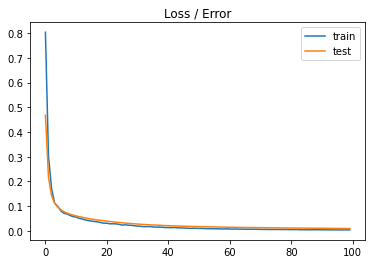

In [9]:
# mlp with scaled inputs outputs on the regression problem using custom loss and custom metric
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model using as loss: penalized_pearson_loss; as metric: pearson_metric AND kears.losses.mean_squared_error
model.compile(loss=penalized_pearson_loss, optimizer=SGD(lr=0.01, momentum=0.9), metrics=[pearson_metric, keras.losses.mean_squared_error])
#model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_e = model.evaluate(trainX, trainy, verbose=1)
test_e = model.evaluate(testX, testy, verbose=1)
print('Train loss: %.3f, Test loss: %.3f' % (train_e[0], test_e[0])) #when using custom loss and custom metric
print('Train metric: %.3f, Test metric: %.3f' % (train_e[1], test_e[1])) #when using custom loss and custom metric
#print('Train loss: %.3f, Test loss: %.3f' % (train_e, test_e)) 
#plot loss during training
plt.title('Loss / Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Since the spearman_loss function for tensorflow 1.5 in spearman_corr_incomplete.ipynb cannot be used without a gradient, you have three options. 

1. You can program a gradient for the function.

2. You can use the spearman_loss function for tensorflow 2.6 in spearman_corr_TSFL2.ipynb (but we have not tested this).

3. You can use the penalized_pearson_loss function instead of the spearman_loss function (as we have done here). But make sure that MSE also converges by checking the MSE_metric.

In [10]:
df = pd.DataFrame(history.history)
df.head(3)

,val_loss,val_pearson_metric,val_mean_squared_error,loss,pearson_metric,mean_squared_error
0,0.467809,0.668800,3.954839,0.803468,0.908922,2.675939
1,0.217232,0.339591,5.264998,0.303012,0.469812,3.897144
2,0.142268,0.219917,4.929149,0.171302,0.265464,4.632336


<AxesSubplot:>

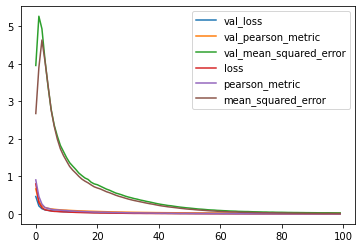

In [11]:
df.plot()

Penalized_pearson_loss has the advantage that it is easy to interpret, unlike MSE or a negative value of R-squared (which can arise in a non-linear model). But it has a disadvantage: When penalized_pearson_loss is used as loss (as it is used here), it minimizes both direction differences and distance differences.  But it does so at different rates: it minimizes direction differences quickly and distance differences more slowly. This is why, when using the penalized_pearson_loss, the mse_metric converges more slowly. But the important thing is that it (MSE, distance) eventually converges after about 70 epochs.

For non-linear models you can use loss: MSE ('mean_squared_error'), and metric: pearson_metric. You can also experiment with loss: penalized_pearson_loss, and metric: kears.losses.mean_squared_error, making sure that convergence is happening. 

To see more about the comparative performance of the penalized_pearson_loss, see pearson_corr_TSFL2_EXTRADOCUMENTATION.ipynb (running the ipynb requires tensorflow 2, but you can see the graphs which show that the penalized_pearson_loss minimizes well while dealing with noisy data.) 